In [3]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

In [17]:
# 1. Estructura del modelo
model = DiscreteBayesianNetwork([
    ("E", "F"),
    ("E", "S"),
    ("F", "V"),
    ("S", "V"),
    ("S", "C"),
    ("V", "D")
])

# 2. CPDs

# P(E)
cpd_E = TabularCPD("E", 2, [[0.99], [0.01]])

# P(F | E)
cpd_F = TabularCPD("F", 2,
                   [[0.9, 0.4],  # F = false
                    [0.1, 0.6]],  # F = true
                   evidence=["E"], evidence_card=[2])

# P(S | E)
cpd_S = TabularCPD("S", 2,
                   [[0.95, 0.2],  # S = false
                    [0.05, 0.8]],  # S = true
                   evidence=["E"], evidence_card=[2])

# P(V | F, S)
cpd_V = TabularCPD("V", 2,
                   [[1.0, 0.5, 0.3, 0.2],  # V = false
                    [0.0, 0.5, 0.7, 0.8]],  # V = true
                   evidence=["F", "S"], evidence_card=[2, 2])

# P(C | S)
cpd_C = TabularCPD("C", 2,
                   [[0.9, 0.25],  # C = false
                    [0.1, 0.75]],  # C = true
                   evidence=["S"], evidence_card=[2])

# P(D | V)
cpd_D = TabularCPD("D", 2,
                   [[1.0, 0.4],  # D = false
                    [0.0, 0.6]],  # D = true
                   evidence=["V"], evidence_card=[2])

# 3. Agregar CPDs al modelo
model.add_cpds(cpd_E, cpd_F, cpd_S, cpd_V, cpd_C, cpd_D)

# 4. Verificar el modelo
assert model.check_model()

# 5. Inferencia: P(E = falso | D = verdadero)
infer = VariableElimination(model)

result = infer.query(variables=["E"], evidence={"D": 1})  # 1 = verdadero
# Imprimir el resultado
print("P(E = falso | D = verdadero):")
print(result)
print("")

# 6. Inciso E

# Ejecutar la inferencia: P(V | E = verdadero)
result = infer.query(variables=["V"], evidence={"E": 1})

# Mostrar el resultado
print("P(V | E = verdadero):")
print(result)
print("")

P(E = falso | D = verdadero):
+------+----------+
| E    |   phi(E) |
+======+==========+
| E(0) |   0.9361 |
+------+----------+
| E(1) |   0.0639 |
+------+----------+

P(V | E = verdadero):
+------+----------+
| V    |   phi(V) |
+======+==========+
| V(0) |   0.3720 |
+------+----------+
| V(1) |   0.6280 |
+------+----------+



In [5]:
# Moralización: convierte el DAG en un grafo no dirigido
moral_graph = model.moralize()

# Mostrar aristas del grafo no dirigido
print("Aristas del modelo moralizado:")
print(moral_graph.edges())

Aristas del modelo moralizado:
[('E', 'F'), ('E', 'S'), ('F', 'V'), ('F', 'S'), ('S', 'V'), ('S', 'C'), ('V', 'D')]


Aristas del modelo moralizado:
[('E', 'F'), ('E', 'S'), ('F', 'V'), ('F', 'S'), ('S', 'V'), ('S', 'C'), ('V', 'D')]


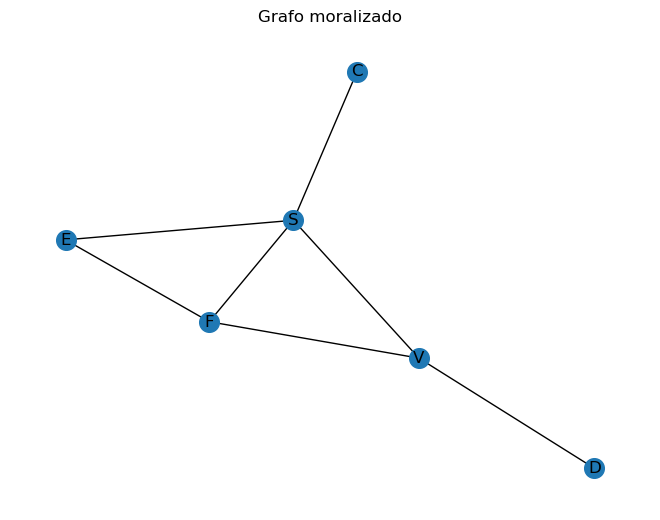

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

# Convertir el grafo moralizado a un grafo de networkx
nx_moral_graph = nx.Graph()
nx_moral_graph.add_edges_from(moral_graph.edges())
nx_moral_graph.add_nodes_from(moral_graph.nodes())

# Mostrar aristas del grafo no dirigido
print("Aristas del modelo moralizado:")
print(nx_moral_graph.edges())

nx.draw(nx_moral_graph, with_labels=True, node_size=200, font_size=12)
plt.title("Grafo moralizado")
plt.show()

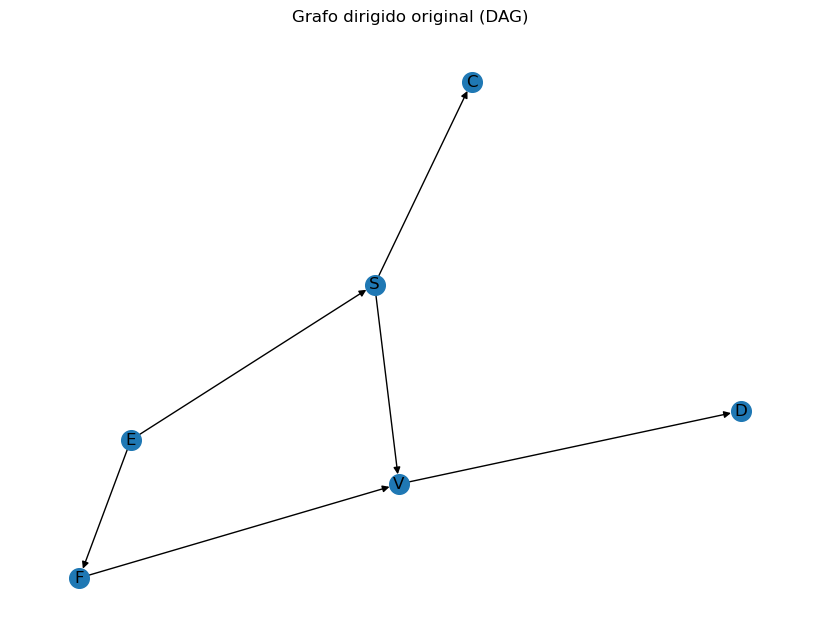

In [ ]:
# Convertir el modelo a un grafo dirigido de networkx
nx_dag = nx.DiGraph()
nx_dag.add_edges_from(model.edges())
nx_dag.add_nodes_from(model.nodes())

# Dibujar el grafo dirigido
plt.figure(figsize=(8, 6))
nx.draw(nx_dag, with_labels=True, node_size=200, font_size=12, arrows=True)
plt.title("Grafo dirigido original (DAG)")
plt.show()

Extra: Ejercicio 2

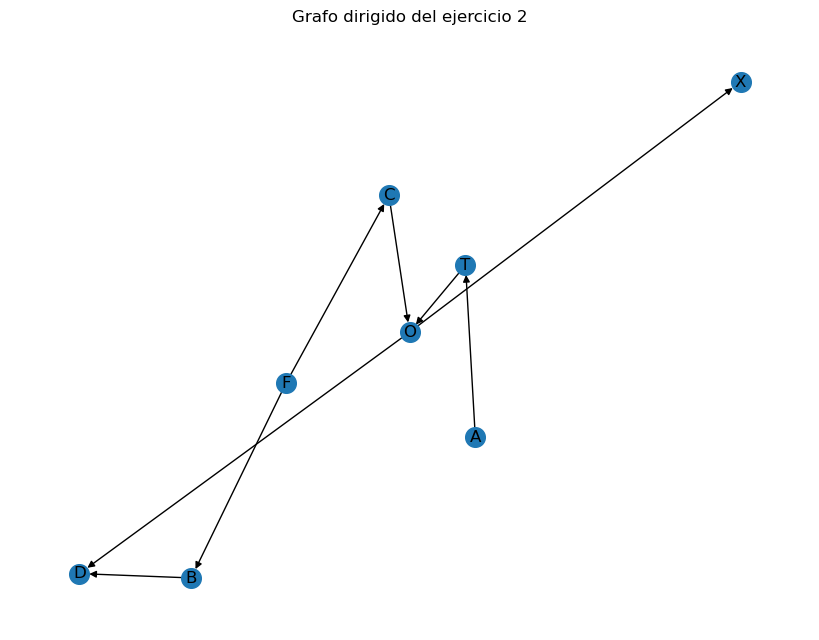

a) T ⊥⊥ F | ['D'] → DEPENDIENTES (FALSO)
b) C ⊥⊥ B | ['F'] → INDEPENDIENTES (VERDADERO)
c) A ⊥⊥ F | ['C'] → INDEPENDIENTES (VERDADERO)
d) A ⊥⊥ F | ['C', 'D'] → DEPENDIENTES (FALSO)


In [ ]:
# Definir el modelo bayesiano con las relaciones del ejercicio 2

model = DiscreteBayesianNetwork([
    ("A", "T"),
    ("T", "O"),
    ("C", "O"),
    ("F", "C"),
    ("F", "B"),
    ("O", "X"),
    ("O", "D"),
    ("B", "D")
])

nx_dag_ex2 = nx.DiGraph()
nx_dag_ex2.add_edges_from(model.edges())
nx_dag_ex2.add_nodes_from(model.nodes())

# Dibujar el grafo dirigido
plt.figure(figsize=(8, 6))
nx.draw(nx_dag_ex2, with_labels=True, node_size=200, font_size=12, arrows=True)
plt.title("Grafo dirigido del ejercicio 2")
plt.show()

# Definir los trails y observaciones de los incisos
trails = {
    "a": ("T", "F", ["D"]),
    "b": ("C", "B", ["F"]),
    "c": ("A", "F", ["C"]),
    "d": ("A", "F", ["C", "D"])
}

# Verificar cada independencia condicional
for label, (x, y, evidence) in trails.items():
    # Obtener los nodos alcanzables desde x, dado evidence
    active_trails = model.active_trail_nodes(x, observed=evidence)
    # Verificar si y está en los nodos alcanzables
    active = y in active_trails[x]
    result = "DEPENDIENTES (FALSO)" if active else "INDEPENDIENTES (VERDADERO)"
    print(f"{label}) {x} ⊥⊥ {y} | {evidence} → {result}")